## Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [1]:
%run data_loader.py

Data loaded


In [3]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sn
import matplotlib.pyplot as plt
import itertools
import math

In [5]:
file_base_name = "data/BBC News {}.csv"
test_data = pd.read_csv(file_base_name.format("Test"))
train_data = pd.read_csv(file_base_name.format("Train"))

In [7]:
print(train_data.info())
print(train_data.describe())
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None
         ArticleId
count  1490.000000
mean   1119.696644
std     641.826283
min       2.000000
25%     565.250000
50%    1112.500000
75%    1680.750000
max    2224.000000


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [14]:
print(test_data.info())
test_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [16]:
# Extracting labels
labels = train_data["Category"].unique().tolist()
labels

['business', 'tech', 'politics', 'sport', 'entertainment']

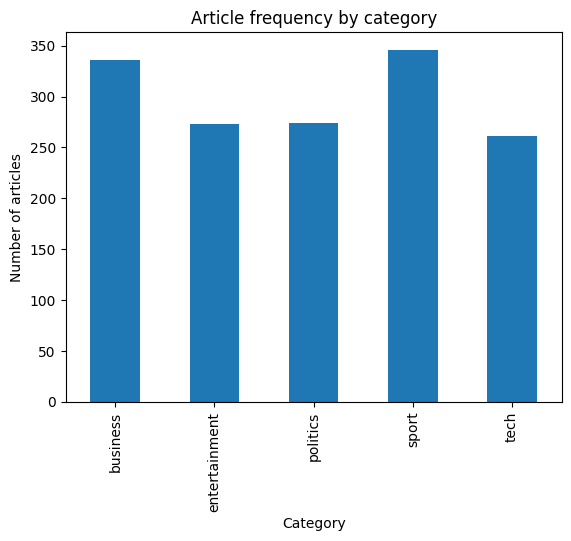

In [28]:
count_by_labels = train_data.groupby("Category").count().iloc[:,0]
count_by_labels.plot.bar(title="Article frequency by category", ylabel="Number of articles")
plt.show()